In [8]:
import pandas as pd
import numpy as np
from scipy.special import softmax
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
df = pd.read_csv("yogurt_data.csv")

# 定义品牌标签（人工命名）和实际列名映射
brands = ['A', 'B', 'C', 'D']   # 你可以将它们改为真实品牌名
purchase_cols = ['y1', 'y2', 'y3', 'y4']
price_cols = ['p1', 'p2', 'p3', 'p4']

# 添加购买总数并筛选至少购买过一次的观测
df['total'] = df[purchase_cols].sum(axis=1)
df = df[df['total'] > 0].copy()

df = df.sample(n=50, random_state=42).copy()

# 构造选择概率矩阵
for brand, col in zip(brands, purchase_cols):
    df[f'choice_{brand}'] = df[col] / df['total']


In [9]:
# 生成模型输入
X_price = df[price_cols].values
Y_share = df[[f'choice_{b}' for b in brands]].values

# 数值稳定的 softmax 函数
def stable_softmax(x):
    x = x - np.max(x)
    exps = np.exp(x)
    return exps / np.sum(exps)

# 参数解包函数：2类 × 4品牌 × (截距 + 价格)
def unpack_params(params):
    intercepts = np.array(params[:8]).reshape(2, 4)
    price_coefs = np.array(params[8:]).reshape(2, 4)
    return intercepts, price_coefs

# Latent-Class Log-Likelihood 函数（数值稳定 + 对数版本）
def latent_class_loglike(params):
    intercepts, price_coefs = unpack_params(params)
    log_likelihood = 0
    eps = 1e-10  # 避免 log(0)
    for i in range(len(df)):
        segment_logprobs = []
        for s in range(2):
            utilities = intercepts[s] + price_coefs[s] * X_price[i]
            probs = stable_softmax(utilities)
            logprob = np.sum(Y_share[i] * np.log(probs + eps))  # log-likelihood
            segment_logprobs.append(np.log(0.5) + logprob)  # 均等先验
        max_log = np.max(segment_logprobs)
        log_likelihood += max_log + np.log(np.sum(np.exp(np.array(segment_logprobs) - max_log)))
    return -log_likelihood

In [10]:
# 初始化参数（带扰动）
np.random.seed(42)
init_params = np.random.normal(loc=0.0, scale=0.1, size=16)

# 优化器调用
res = minimize(
    latent_class_loglike,
    init_params,
    method="L-BFGS-B",
    options={"maxfun": 500, "disp": True}
)

# 解包结果
intercepts, price_coefs = unpack_params(res.x)

# 构建结果 DataFrame
results = pd.DataFrame({
    "Brand": brands * 2,
    "Segment": ["Segment 1"] * 4 + ["Segment 2"] * 4,
    "Intercept": intercepts.flatten(),
    "PriceCoef": price_coefs.flatten()
})

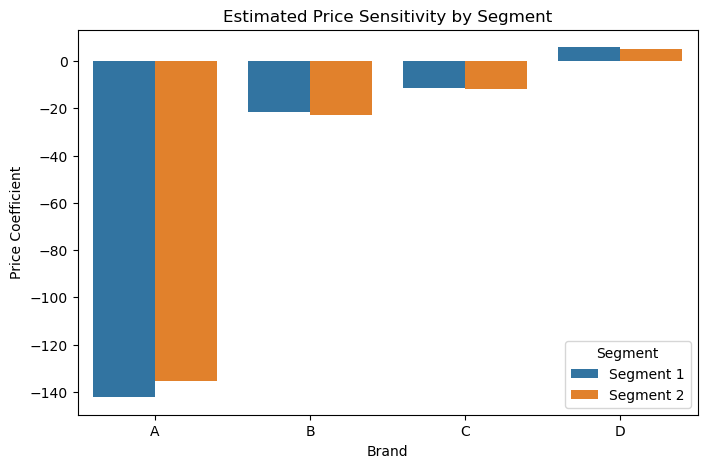

In [11]:
# 可视化价格敏感度差异
plt.figure(figsize=(8,5))
sns.barplot(data=results, x="Brand", y="PriceCoef", hue="Segment")
plt.title("Estimated Price Sensitivity by Segment")
plt.ylabel("Price Coefficient")
plt.show()